# Importing And Installing Necessary Libraries

In [ ]:
!pip install -q keras-tuner mlflow gradio catboost

In [58]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from keras.optimizers import Adam , SGD

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, roc_curve, auc , precision_score, recall_score, f1_score, roc_auc_score

from sklearn.model_selection import RandomizedSearchCV , StratifiedKFold
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import gradio as gr

import os
from google.colab import drive
import datetime

import mlflow
import mlflow.keras

# Reading Data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/CKD/DATASET/balanced_classes_dataset.csv")

## Data Wrangling

In [ ]:
data = pd.get_dummies(data,columns=["Gender"],drop_first=False)

In [ ]:
# conversion on the creatinine level from Umol/L to mg/dl
data['Creatinine (mg/dl)'] = data['Creatinine (Umol/L)'] * 0.0113

## Correlation Plot

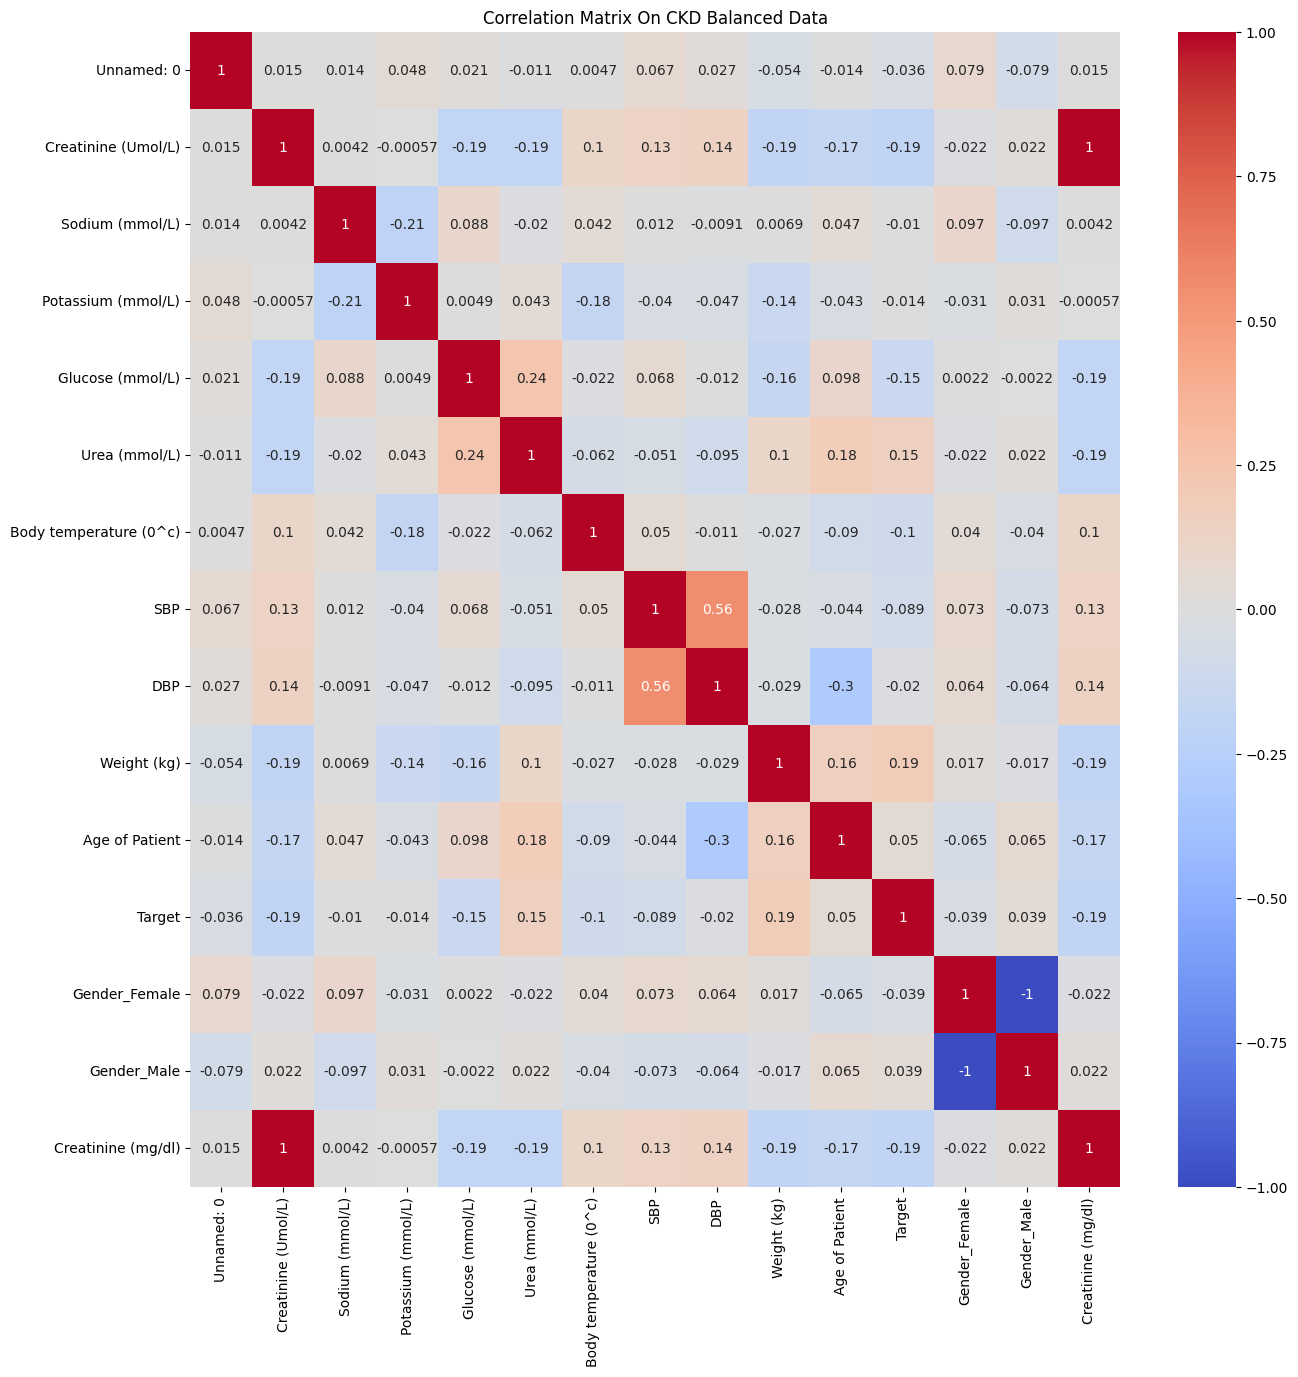

In [ ]:
data_corr = data.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(data_corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix On CKD Balanced Data")
plt.show()

## Splitting Of Data

In [ ]:
X = data.drop(["Target", "Creatinine (Umol/L)", "Unnamed: 0"], axis=1)
y = data["Target"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Helper Functions : Deep Learning

## Plotting Training History Function

In [ ]:
def plot_training_history(history):
    """
    Plots training and validation loss and accuracy from a Keras training history object.

    Parameters:
        history: A Keras History object returned by model.fit().
    """
    plt.figure(figsize=(15, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

## Plot Training History Function : Folds

In [ ]:
def plot_all_fold_histories(histories):
    """
    Plots training and validation loss and accuracy for all folds side by side.

    Parameters:
        histories: List of Keras History objects.
    """
    num_folds = len(histories)
    fig, axes = plt.subplots(num_folds, 2, figsize=(12, 4 * num_folds))

    if num_folds == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, history in enumerate(histories):
        # Plot loss
        axes[i, 0].plot(history.history['loss'], label='Train Loss')
        axes[i, 0].plot(history.history['val_loss'], label='Val Loss')
        axes[i, 0].set_title(f'Fold {i+1} - Loss')
        axes[i, 0].set_xlabel('Epochs')
        axes[i, 0].set_ylabel('Loss')
        axes[i, 0].grid(True)
        axes[i, 0].legend()

        # Plot accuracy
        axes[i, 1].plot(history.history['accuracy'], label='Train Acc')
        axes[i, 1].plot(history.history['val_accuracy'], label='Val Acc')
        axes[i, 1].set_title(f'Fold {i+1} - Accuracy')
        axes[i, 1].set_xlabel('Epochs')
        axes[i, 1].set_ylabel('Accuracy')
        axes[i, 1].grid(True)
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

## Model Classification Report Function

In [ ]:
def model_classification_report(model, X_test, y_test):
    """
    Generates and prints the classification report for a trained classification model.

    Parameters:
        model: Trained Keras model.
        X_test: Test features.
        y_test: True labels.
    """
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Get the predicted class with the highest probability
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred))

## Confusion Matrix Function

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=None, title='Confusion Matrix', cmap='Blues'):
    """
    Plots a confusion matrix using seaborn's heatmap for multiclass classification.

    Parameters:
        y_true: Array of true labels.
        y_pred: Array of predicted labels.
        labels: Optional list of class names.
        title: Title for the plot.
        cmap: Colormap for the heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

## Model Training With Early Stoppings

In [ ]:
def train_model_with_early_stopping(model, X_train, y_train, X_val, y_val,
                                     epochs=100, batch_size=32, patience=10, verbose=1):
    """
    Trains a Keras model with early stopping.

    Parameters:
        model: Compiled Keras model.
        X_train: Training features.
        y_train: Training labels.
        X_val: Validation features.
        y_val: Validation labels.
        epochs: Maximum number of training epochs.
        batch_size: Batch size for training.
        patience: Number of epochs with no improvement before stopping.
        verbose: Verbosity level (0, 1, or 2).

    Returns:
        history: Keras History object containing training history.
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=verbose
    )

    return history

## Saving Model To Drive Function

In [ ]:
def save_model_to_drive(model, model_name_prefix):
  """Saves a Keras model to a specified folder in Google Drive with a timestamp.

  Args:
    model: The Keras model to save.
    model_name_prefix: The prefix for the model filename (e.g., 'best_model_CKD').
  """
  folder_path = '/content/drive/MyDrive/CKD/ckd model artefacts'
  os.makedirs(folder_path, exist_ok=True)  # Create folder if it doesn't exist

  # Get current timestamp
  timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

  # Create filename with timestamp
  model_filename = f"{model_name_prefix}_{timestamp}.keras"

  save_path = os.path.join(folder_path, model_filename)
  model.save(save_path)
  print(f"Model saved to: {save_path}")

## SGD Model Function

In [ ]:
def create_sgd_model(input_dim, num_classes):
    """
    Builds and compiles a Keras model using the SGD optimizer.
    """
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=SGD(learning_rate=0.01, momentum=0.9),
        metrics=['accuracy']
    )
    return model

## Adam Model Function

In [ ]:
def create_adam_model(input_dim, num_classes):
    """
    Builds and compiles a Keras model using the Adam optimizer.
    """
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    return model

## Model Experimentation : Hyper Parameter Tuning Model

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_input', min_value=64, max_value=256, step=32),
        activation='relu',
        # Use the stored input dimension
        input_dim=X_train.shape[1]
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_input', 0.1, 0.5, step=0.1)))

    for i in range(hp.Int('num_hidden_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', 32, 128, step=32), activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

    model.add(Dense(6, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Model Tuning Experimentation

In [ ]:
input_dim = X_train.shape[1]

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='ffnn_tuning'
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 18s]
val_accuracy: 0.7833333611488342

Best val_accuracy So Far: 0.8333333134651184
Total elapsed time: 00h 04m 47s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,974 (78.02 KB)

 Trainable params: 19,462 (76.02 KB)

 Non-trainable params: 512 (2.00 KB)

# FFNN Training On SGD Optimizier : Stratified K-Fold

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_histories = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print(f"\nTraining fold {fold+1}...")

    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    model_sgd = create_sgd_model(input_dim=X.shape[1], num_classes=6)

    history = train_model_with_early_stopping(
        model_sgd,
        X_train_fold, y_train_fold,
        X_val_fold, y_val_fold,
        epochs=100,
        batch_size=32,
        patience=10,
        verbose=0
    )

    fold_histories.append(history)

    _, accuracy = model_sgd.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold+1} Accuracy: {accuracy:.4f}")
    fold_accuracies.append(accuracy)

print("\nCross-Validation Results")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies):.4f}")


Training fold 1...
Fold 1 Accuracy: 0.7083

Training fold 2...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2 Accuracy: 0.7917

Training fold 3...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3 Accuracy: 0.7167

Training fold 4...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4 Accuracy: 0.5250

Training fold 5...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5 Accuracy: 0.7083

Cross-Validation Results
Mean Accuracy: 0.6900
Standard Deviation: 0.0883


## Training Metric : Folds Accuracy and Loss

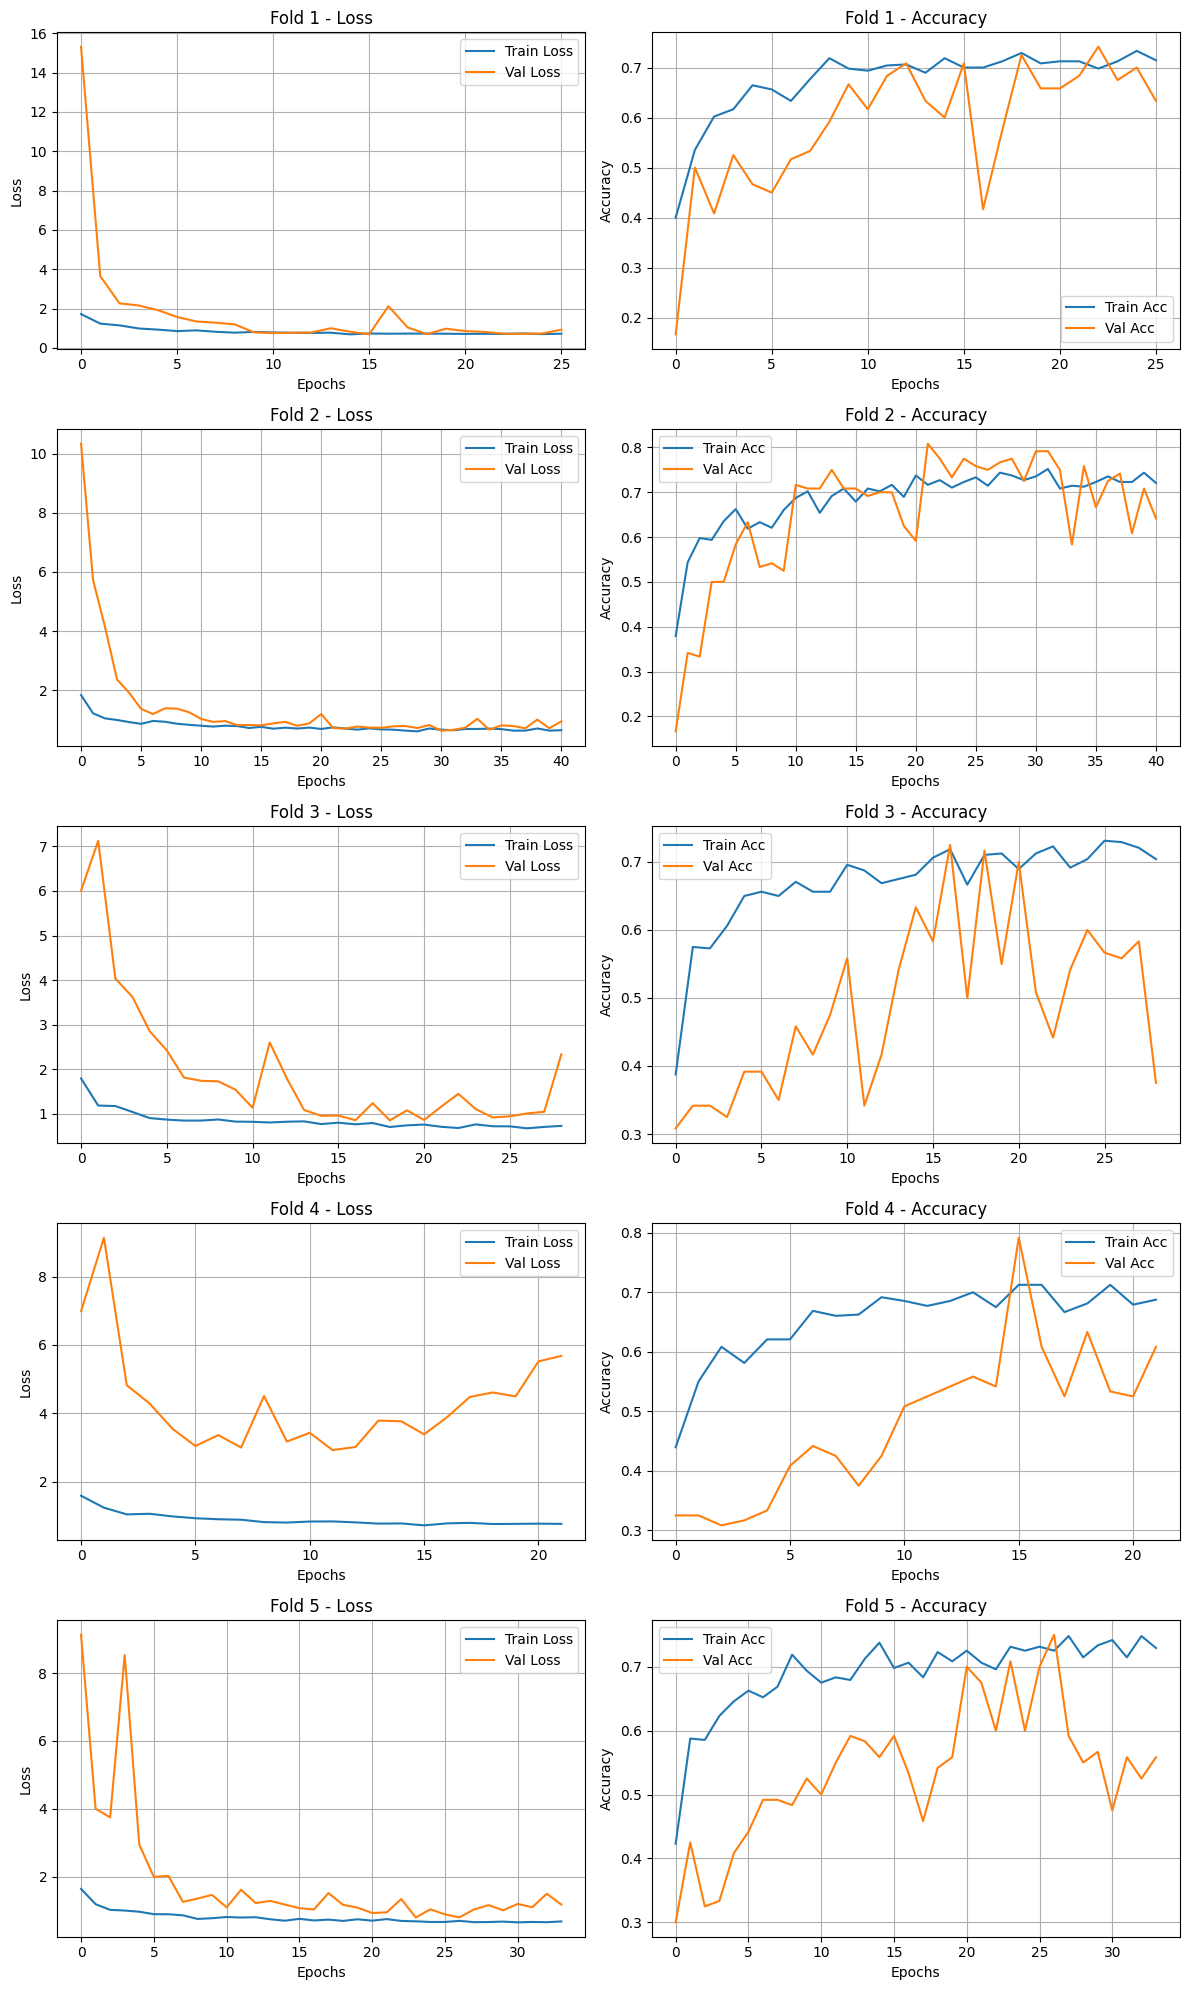

In [ ]:
plot_all_fold_histories(fold_histories)

## Classification Report  : SGD Optimizier

In [ ]:
y_pred_sgd = np.argmax(model_sgd.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_sgd))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         8
           1       0.67      0.73      0.70        11
           2       1.00      1.00      1.00         9
           3       0.69      0.92      0.79        12
           4       0.80      0.89      0.84         9
           5       0.60      0.27      0.38        11

    accuracy                           0.72        60
   macro avg       0.71      0.72      0.70        60
weighted avg       0.71      0.72      0.70        60



## Confusion Matrix : SGD Optimizier

Text(0.5, 1.0, 'Confusion Matrix - SGD Optimizer')

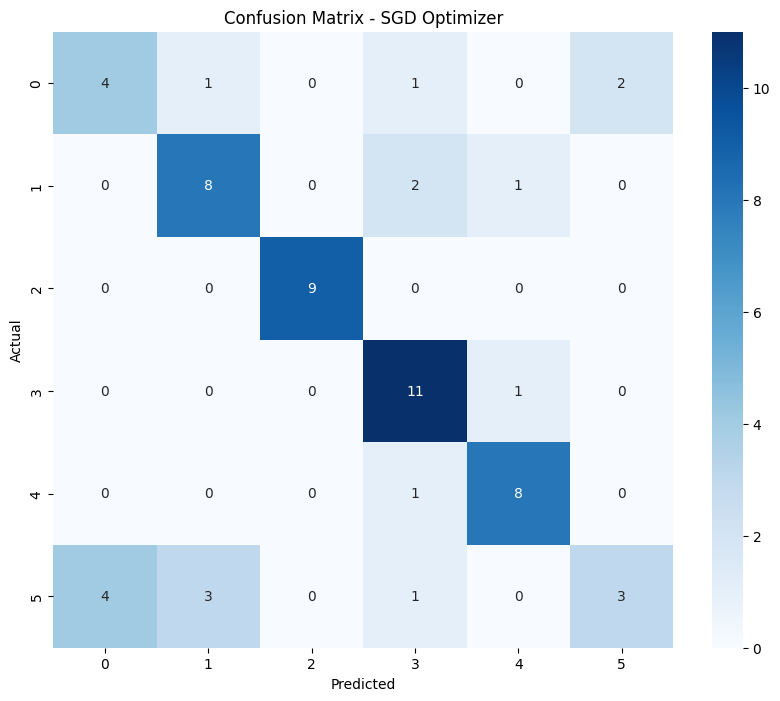

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred_sgd), annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SGD Optimizer')

In [ ]:
save_model_to_drive(model_sgd, 'model_sgd_CKD_balanced')

Model saved to: /content/drive/MyDrive/CKD/ckd model artefacts/model_sgd_CKD_balanced_20250701_090347.keras


# FFN Training On Adam Optimizier : Stratified KFold

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
adam_fold_accuracies = []
adam_fold_histories = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print(f"\nTraining fold {fold+1} (Adam)...")

    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    model_adam = create_adam_model(input_dim=X.shape[1], num_classes=6)

    history = train_model_with_early_stopping(
        model_adam,
        X_train_fold, y_train_fold,
        X_val_fold, y_val_fold,
        epochs=100,
        batch_size=32,
        patience=10,
        verbose=0
    )

    adam_fold_histories.append(history)

    _, accuracy = model_adam.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold+1} Accuracy: {accuracy:.4f}")
    adam_fold_accuracies.append(accuracy)

print("\nAdam Cross-Validation Results")
print(f"Mean Accuracy: {np.mean(adam_fold_accuracies):.4f}")
print(f"Standard Deviation: {np.std(adam_fold_accuracies):.4f}")


Training fold 1 (Adam)...
Fold 1 Accuracy: 0.7000

Training fold 2 (Adam)...
Fold 2 Accuracy: 0.6917

Training fold 3 (Adam)...
Fold 3 Accuracy: 0.7750

Training fold 4 (Adam)...
Fold 4 Accuracy: 0.6417

Training fold 5 (Adam)...
Fold 5 Accuracy: 0.7250

Adam Cross-Validation Results
Mean Accuracy: 0.7067
Standard Deviation: 0.0436


## Training Metric : Folds Accuracy and Loss

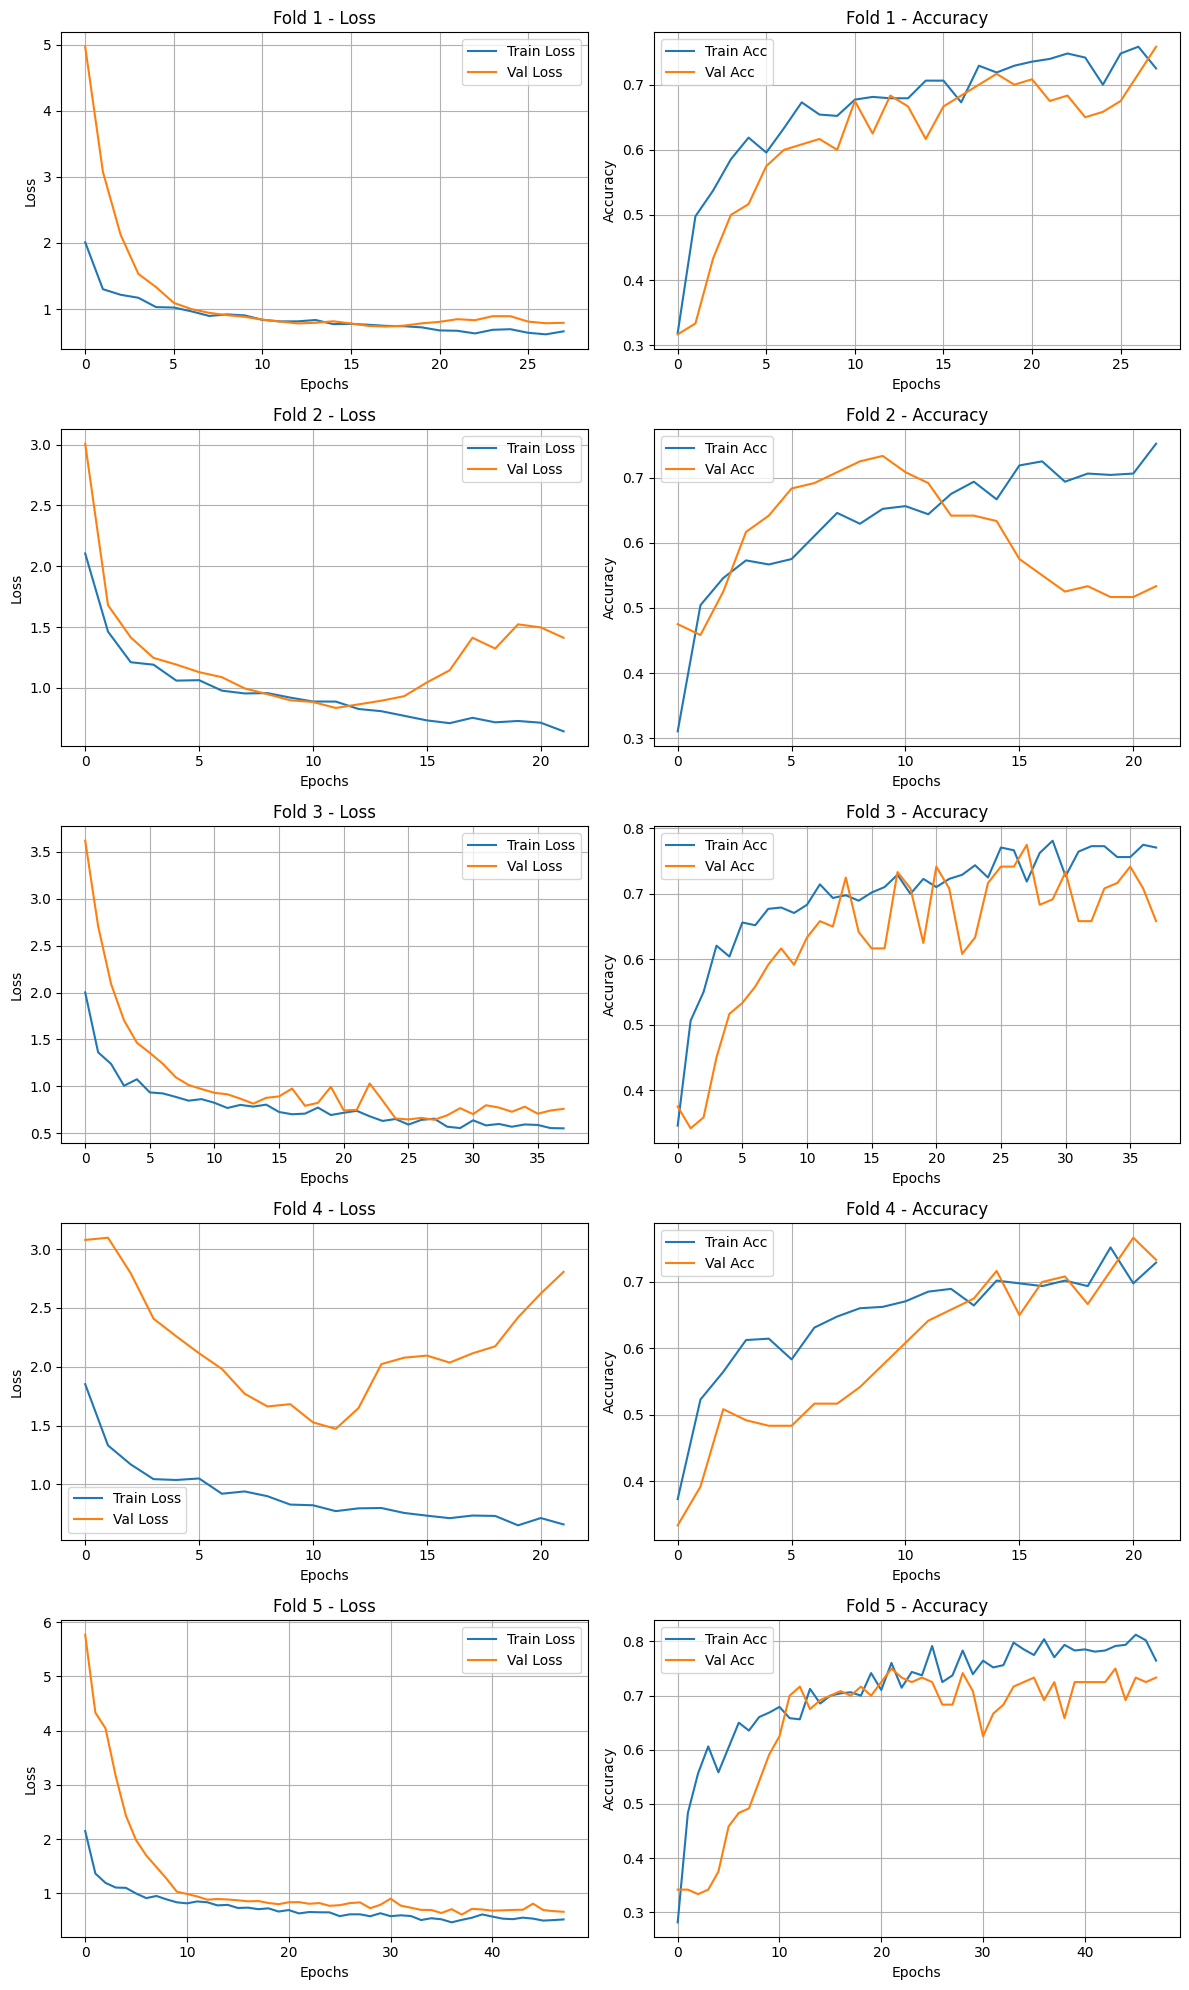

In [ ]:
plot_all_fold_histories(adam_fold_histories)

## Classification Report  : SGD Optimizier

In [ ]:
y_pred_adam = np.argmax(model_adam.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_adam))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       1.00      0.91      0.95        11
           2       1.00      1.00      1.00         9
           3       1.00      0.92      0.96        12
           4       0.82      1.00      0.90         9
           5       0.78      0.64      0.70        11

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.86        60
weighted avg       0.88      0.87      0.87        60



## Confusion Matrix : SGD Optimizier

Text(0.5, 1.0, 'Confusion Matrix - Adam Optimizer')

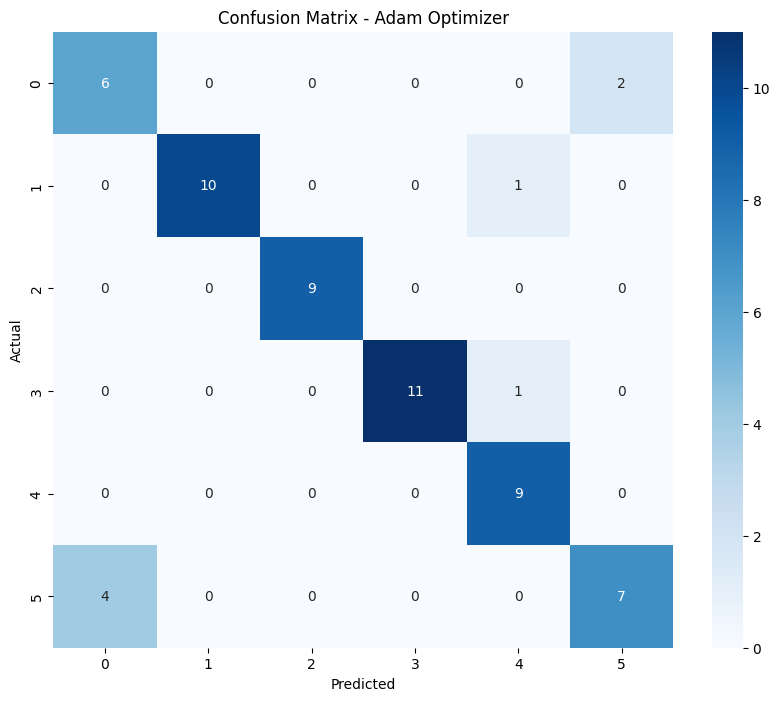

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred_adam), annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Adam Optimizer')

## Model Architecture Plot

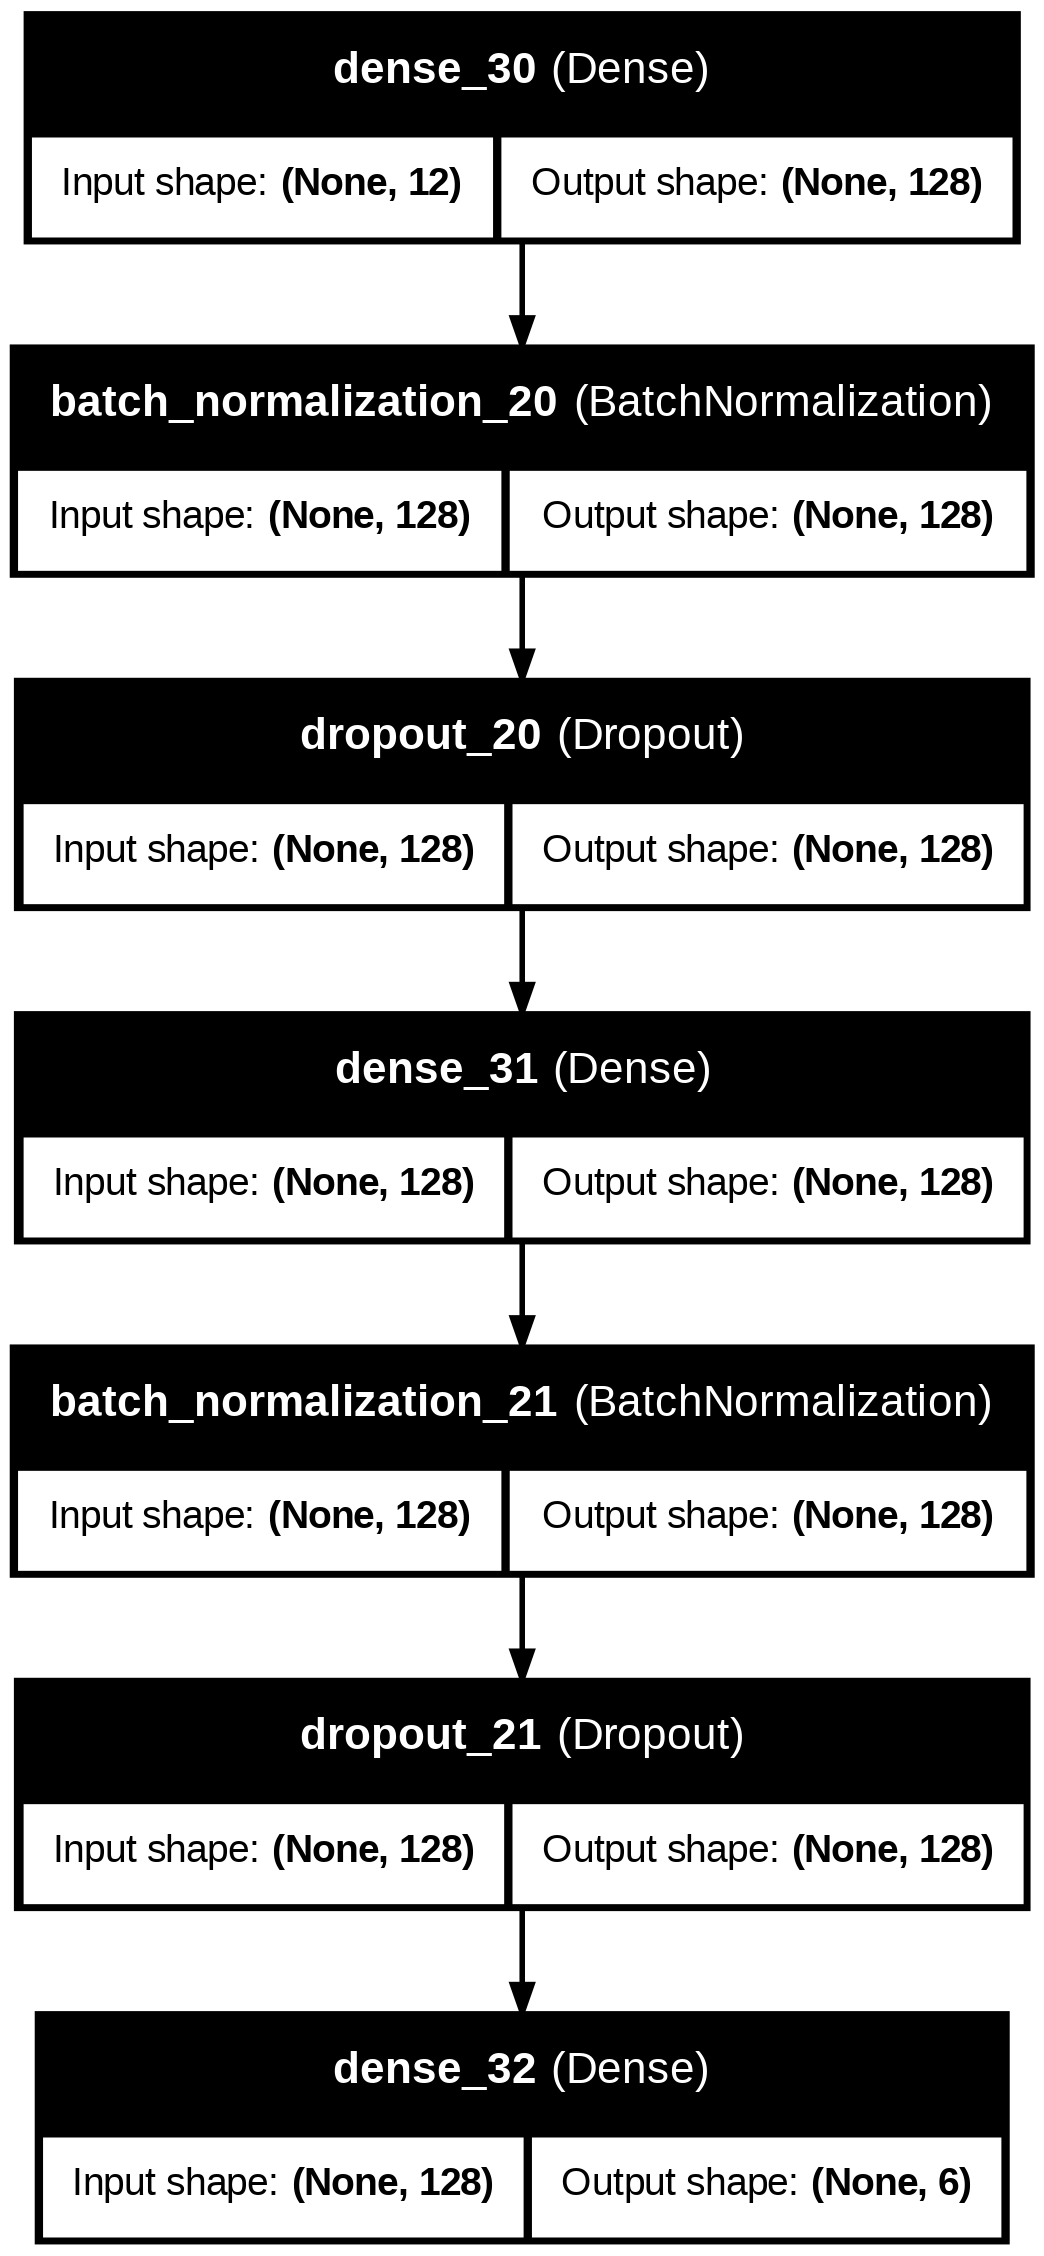

In [ ]:
tf.keras.utils.plot_model(model_adam, to_file='model.png', show_shapes=True, show_layer_names=True)

# Helper Functions : Machine Learning

## Model Tuning : Hyperparamter Tuning

In [ ]:
def tune_model(model, param_grid, X, y, n_iter=10, n_splits=5, scoring='accuracy'):
    """
    Tune a model using Stratified K-Fold and RandomizedSearchCV.
    Returns: (best_estimator, best_params)
    """
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=kfold,
        scoring=scoring,
        n_jobs=1,
        verbose=0,
        random_state=42
    )

    search.fit(X, y)
    return search.best_estimator_, search.best_params_

## Model Training : Tree Algorithms

In [ ]:
def train_tree_models(X, y):
    results = {}

    rf_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    rf_model = RandomForestClassifier(random_state=42)
    best_rf, _ = tune_model(rf_model, rf_grid, X, y)
    results['RandomForest'] = best_rf

    dt_grid = {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    }
    dt_model = DecisionTreeClassifier(random_state=42)
    best_dt, _ = tune_model(dt_model, dt_grid, X, y)
    results['DecisionTree'] = best_dt

    return results

## Model Training : Boosting Algorithms

In [ ]:
def train_boosting_models(X, y):
    results = {}

    xgb_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1]
    }
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    best_xgb, _ = tune_model(xgb_model, xgb_grid, X, y)
    results['XGBoost'] = best_xgb

    cat_grid = {
        'depth': [4, 6],
        'learning_rate': [0.01, 0.1],
        'iterations': [100, 200]
    }
    cat_model = CatBoostClassifier(verbose=0, random_state=42)
    best_cat, _ = tune_model(cat_model, cat_grid, X, y)
    results['CatBoost'] = best_cat

    ada_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1, 1.0]
    }
    ada_model = AdaBoostClassifier(random_state=42)
    best_ada, _ = tune_model(ada_model, ada_grid, X, y)
    results['AdaBoost'] = best_ada

    return results

## Model Training : SVM

In [ ]:
def train_svm_model(X, y):
    results = {}

    svm_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear']
    }
    svm_model = SVC(probability=True, random_state=42)
    best_svm, _ = tune_model(svm_model, svm_grid, X, y)
    results['SVM'] = best_svm

    return results

## Model Evaluation : General

In [ ]:
def evaluate_on_test(models_dict, X_test, y_test, average='weighted'):
    results = []

    for name, model in models_dict.items():
        y_pred = model.predict(X_test)

        results.append({
            "Model": name,
            "Accuracy": round(accuracy_score(y_test, y_pred), 4),
            "Precision": round(precision_score(y_test, y_pred, average=average, zero_division=0), 4),
            "Recall": round(recall_score(y_test, y_pred, average=average, zero_division=0), 4),
            "F1-Score": round(f1_score(y_test, y_pred, average=average, zero_division=0), 4),
        })

    return pd.DataFrame(results).sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

## Model Evaluations : Detailed

In [ ]:
def evaluate_detailed(models_dict, X_test, y_test, labels=None, average='weighted'):
    """
    For each model:
    - Print classification report
    - Show confusion matrix
    """
    for name, model in models_dict.items():
        print(f"\n===================== 📌 {name} =====================")

        y_pred = model.predict(X_test)

        # Classification Report
        print("\n📄 Classification Report:")
        print(classification_report(y_test, y_pred, target_names=labels, zero_division=0))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

        # Also print raw matrix
        print("🔢 Confusion Matrix:")
        print(cm)
        print("\n----------------------------------------------------")

## Plot Feature Importance

In [ ]:
def plot_feature_importance(models_dict, feature_names):
    """
    Plot feature importance for models that support it.
    """
    for name, model in models_dict.items():
        print(f"\n📊 Feature Importance - {name}")

        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        elif name == "CatBoost":
            importances = model.get_feature_importance()
        else:
            print(f"⚠️ {name} does not support feature importances directly.")
            continue

        # Prepare DataFrame
        importance_df = (
            pd.DataFrame({
                "Feature": feature_names,
                "Importance": importances
            })
            .sort_values(by="Importance", ascending=False)
        )

        # Plot
        plt.figure(figsize=(8, 5))
        sns.barplot(x="Importance", y="Feature", data=importance_df.head(15), palette="viridis")
        plt.title(f"Top Features - {name}")
        plt.tight_layout()
        plt.show()

# Machine Learning Training

In [ ]:
# Train models
tree_models = train_tree_models(X_train, y_train)
boost_models = train_boosting_models(X_train, y_train)
svm_model = train_svm_model(X_train, y_train)

In [53]:
# Merge all models
all_models = {**tree_models, **boost_models, **svm_model}
test_results_df = evaluate_on_test(all_models, X_test, y_test)
print(test_results_df)

          Model  Accuracy  Precision  Recall  F1-Score
0      CatBoost    0.9167     0.9189  0.9167    0.9171
1       XGBoost    0.9167     0.9161  0.9167    0.9157
2  RandomForest    0.9000     0.9059  0.9000    0.9006
3           SVM    0.8833     0.8927  0.8833    0.8793
4  DecisionTree    0.8500     0.8723  0.8500    0.8574
5      AdaBoost    0.8500     0.8657  0.8500    0.8485


## Machine Learning : Model Evaluations


===================== 📌 RandomForest =====================

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         9
           1       0.78      0.64      0.70        11

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.89        60
weighted avg       0.91      0.90      0.90        60



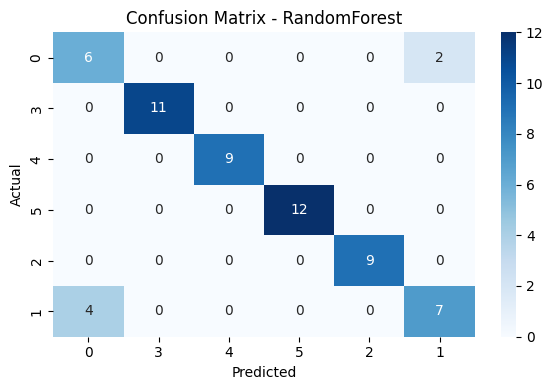

🔢 Confusion Matrix:
[[ 6  0  0  0  0  2]
 [ 0 11  0  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0  9  0]
 [ 4  0  0  0  0  7]]

----------------------------------------------------

===================== 📌 DecisionTree =====================

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.62      0.53         8
           3       1.00      0.82      0.90        11
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         9
           1       0.70      0.64      0.67        11

    accuracy                           0.85        60
   macro avg       0.86      0.85      0.85        60
weighted avg       0.87      0.85      0.86        60



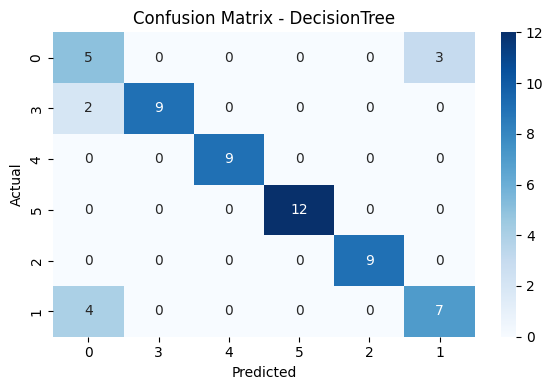

🔢 Confusion Matrix:
[[ 5  0  0  0  0  3]
 [ 2  9  0  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0  9  0]
 [ 4  0  0  0  0  7]]

----------------------------------------------------

===================== 📌 XGBoost =====================

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         9
           1       0.75      0.82      0.78        11

    accuracy                           0.92        60
   macro avg       0.91      0.91      0.91        60
weighted avg       0.92      0.92      0.92        60



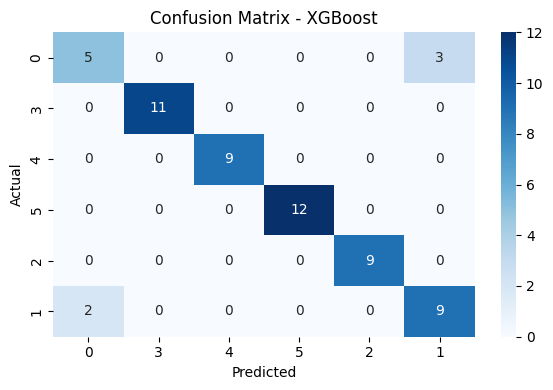

🔢 Confusion Matrix:
[[ 5  0  0  0  0  3]
 [ 0 11  0  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0  9  0]
 [ 2  0  0  0  0  9]]

----------------------------------------------------

===================== 📌 CatBoost =====================

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         9
           1       0.80      0.73      0.76        11

    accuracy                           0.92        60
   macro avg       0.91      0.91      0.91        60
weighted avg       0.92      0.92      0.92        60



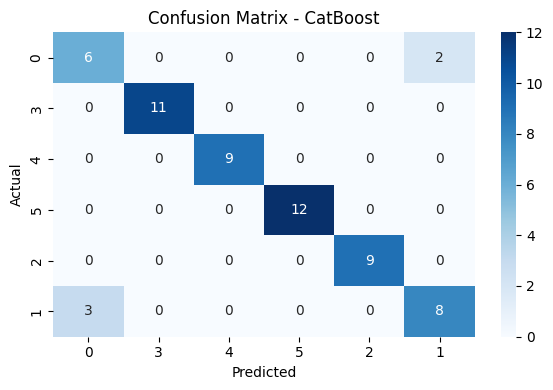

🔢 Confusion Matrix:
[[ 6  0  0  0  0  2]
 [ 0 11  0  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0  9  0]
 [ 3  0  0  0  0  8]]

----------------------------------------------------

===================== 📌 AdaBoost =====================

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         8
           3       0.92      1.00      0.96        11
           4       1.00      1.00      1.00         9
           5       1.00      0.92      0.96        12
           2       1.00      1.00      1.00         9
           1       0.71      0.45      0.56        11

    accuracy                           0.85        60
   macro avg       0.86      0.85      0.84        60
weighted avg       0.87      0.85      0.85        60



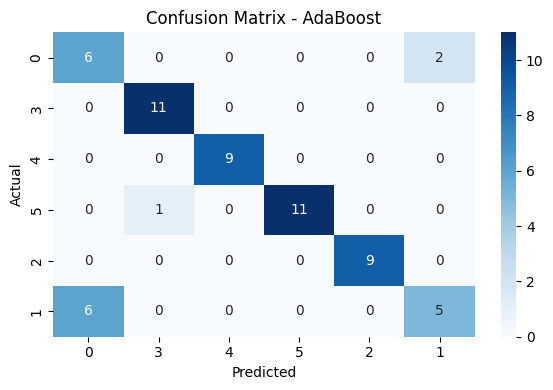

🔢 Confusion Matrix:
[[ 6  0  0  0  0  2]
 [ 0 11  0  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  1  0 11  0  0]
 [ 0  0  0  0  9  0]
 [ 6  0  0  0  0  5]]

----------------------------------------------------

===================== 📌 SVM =====================

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           3       0.85      1.00      0.92        11
           4       1.00      1.00      1.00         9
           5       1.00      0.92      0.96        12
           2       1.00      0.89      0.94         9
           1       0.71      0.91      0.80        11

    accuracy                           0.88        60
   macro avg       0.89      0.87      0.87        60
weighted avg       0.89      0.88      0.88        60



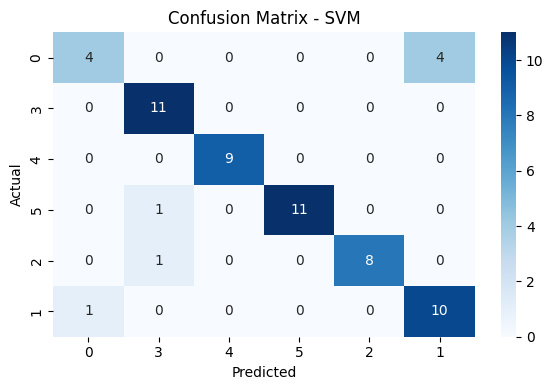

🔢 Confusion Matrix:
[[ 4  0  0  0  0  4]
 [ 0 11  0  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  1  0 11  0  0]
 [ 0  1  0  0  8  0]
 [ 1  0  0  0  0 10]]

----------------------------------------------------


In [57]:
evaluate_detailed(all_models, X_test, y_test, labels=[str(label) for label in y.unique()])

## Feature Importance


📊 Feature Importance - RandomForest


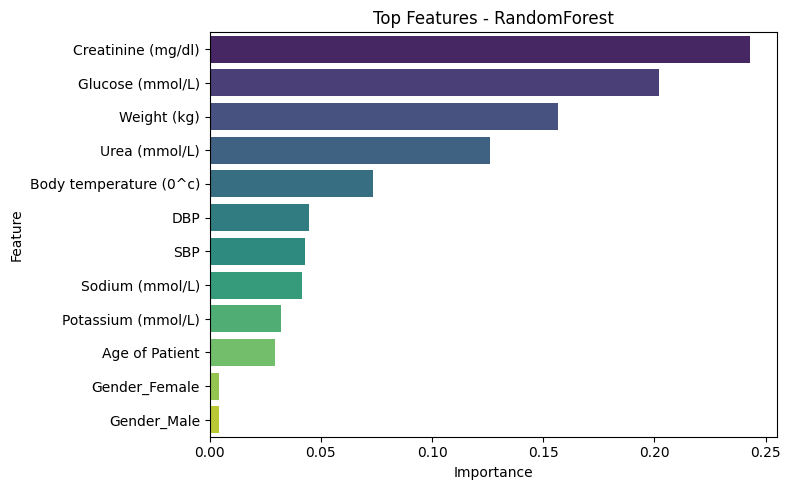


📊 Feature Importance - DecisionTree


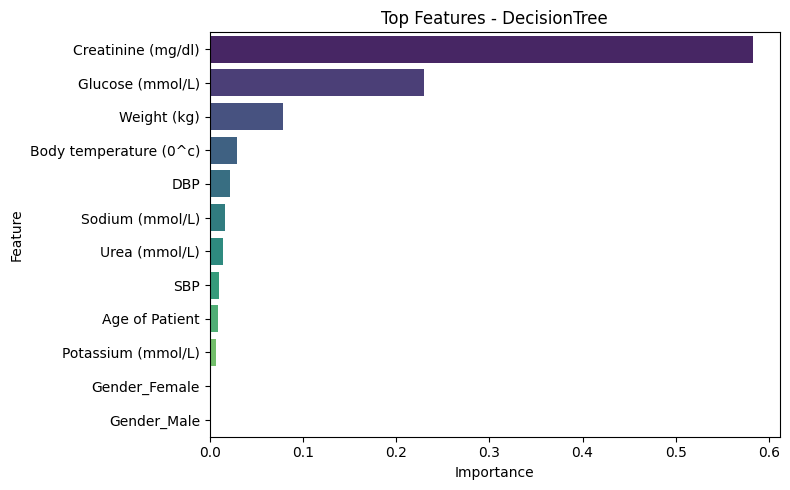


📊 Feature Importance - XGBoost


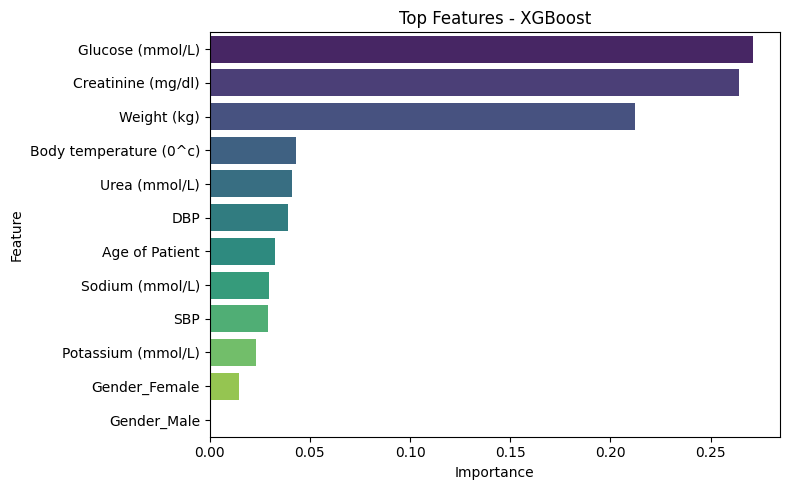


📊 Feature Importance - CatBoost


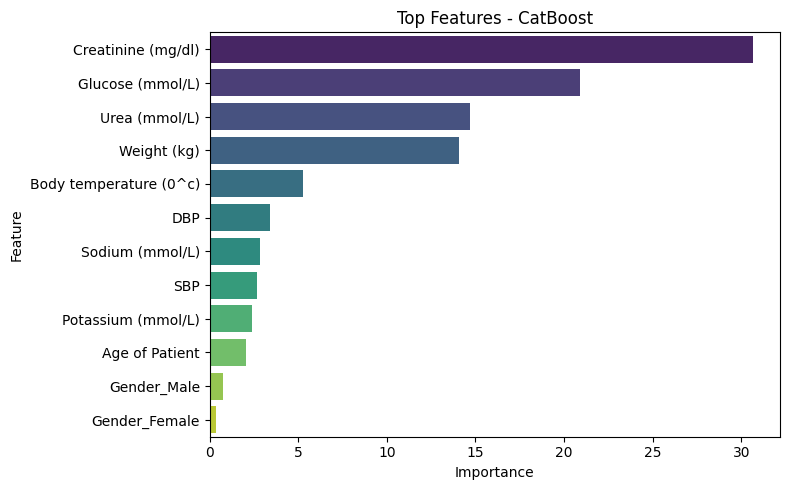


📊 Feature Importance - AdaBoost


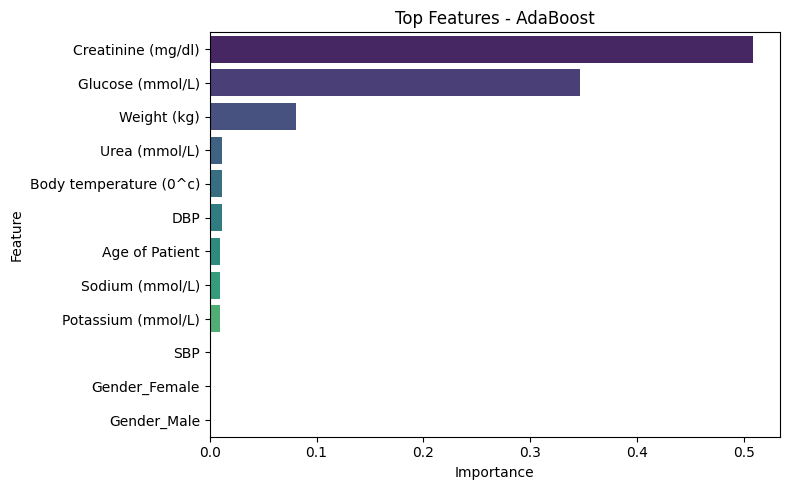


📊 Feature Importance - SVM
⚠️ SVM does not support feature importances directly.


In [60]:
feature_names = X_train.columns.tolist()
plot_feature_importance(all_models, feature_names)